Using downloaded and verified file: ../VOC\VOCtrainval_06-Nov-2007.tar
Extracting ../VOC\VOCtrainval_06-Nov-2007.tar to ../VOC
loss_dict = {}


INFO:postprocess_visual.object_detection_visualizer:Using device: cuda


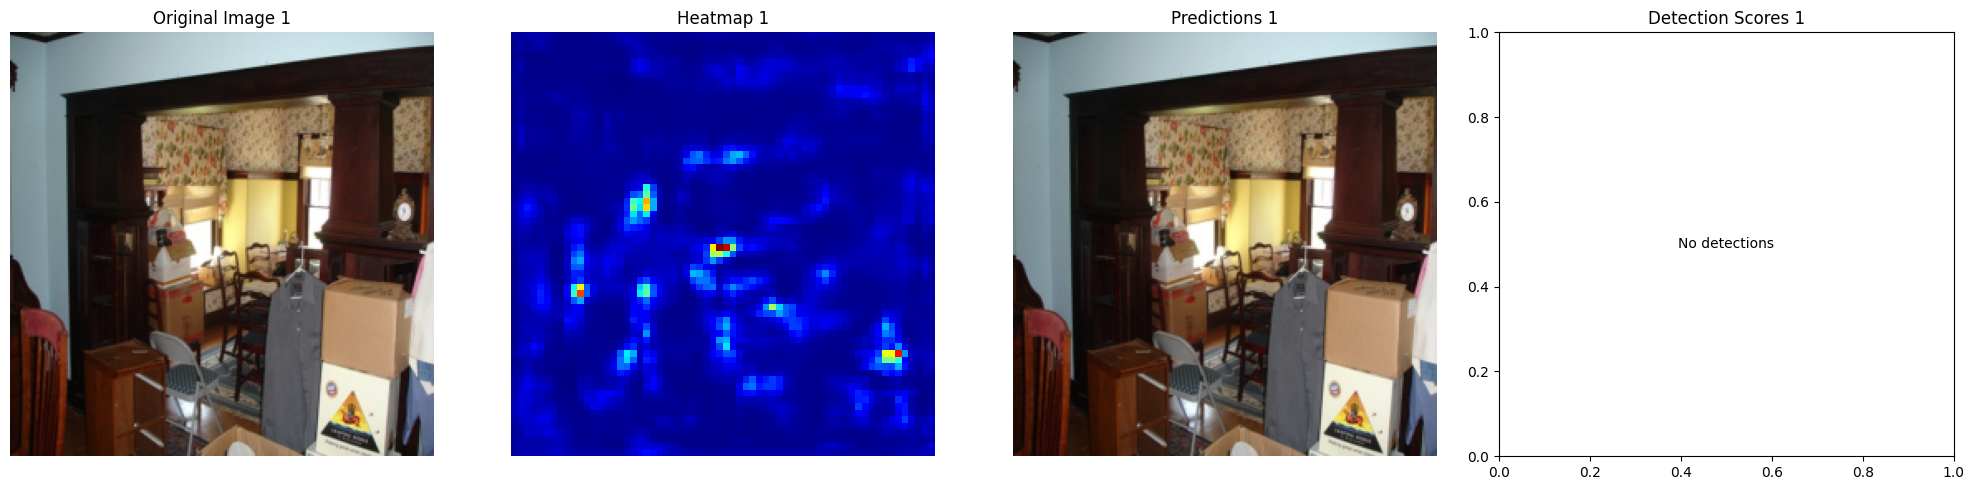

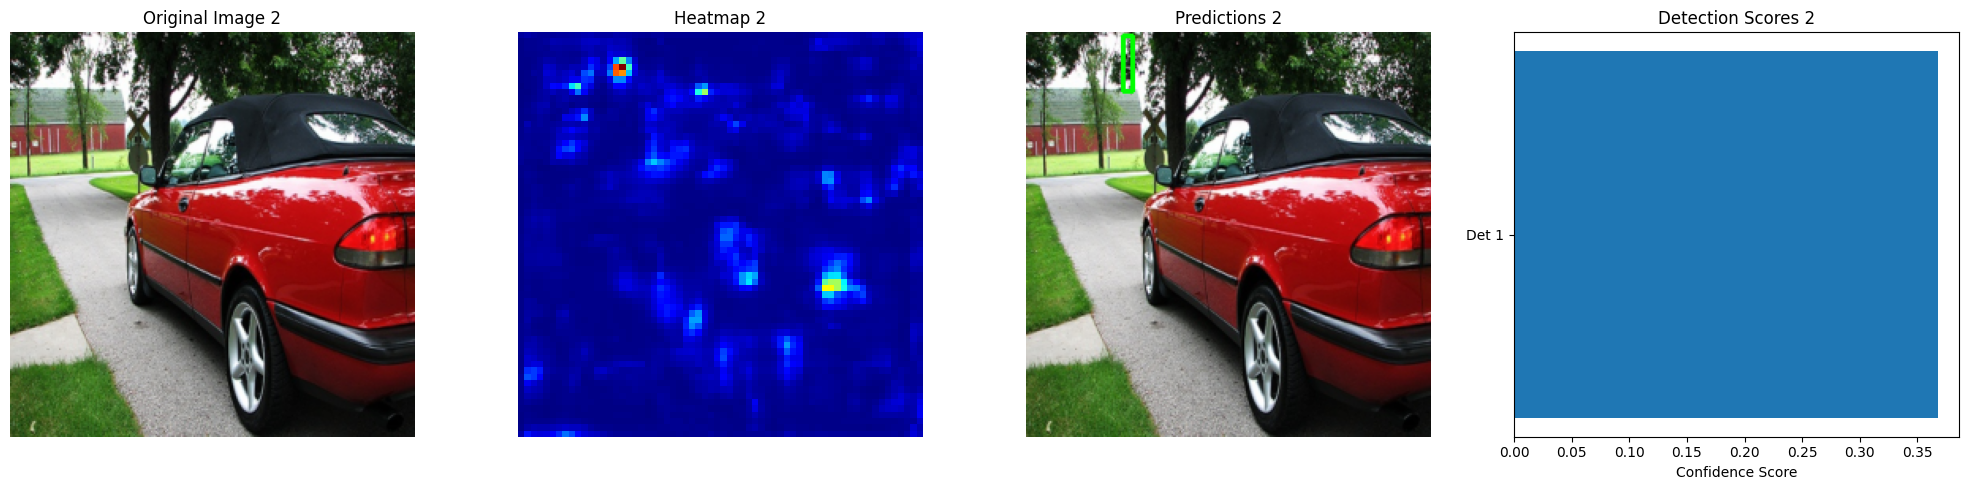

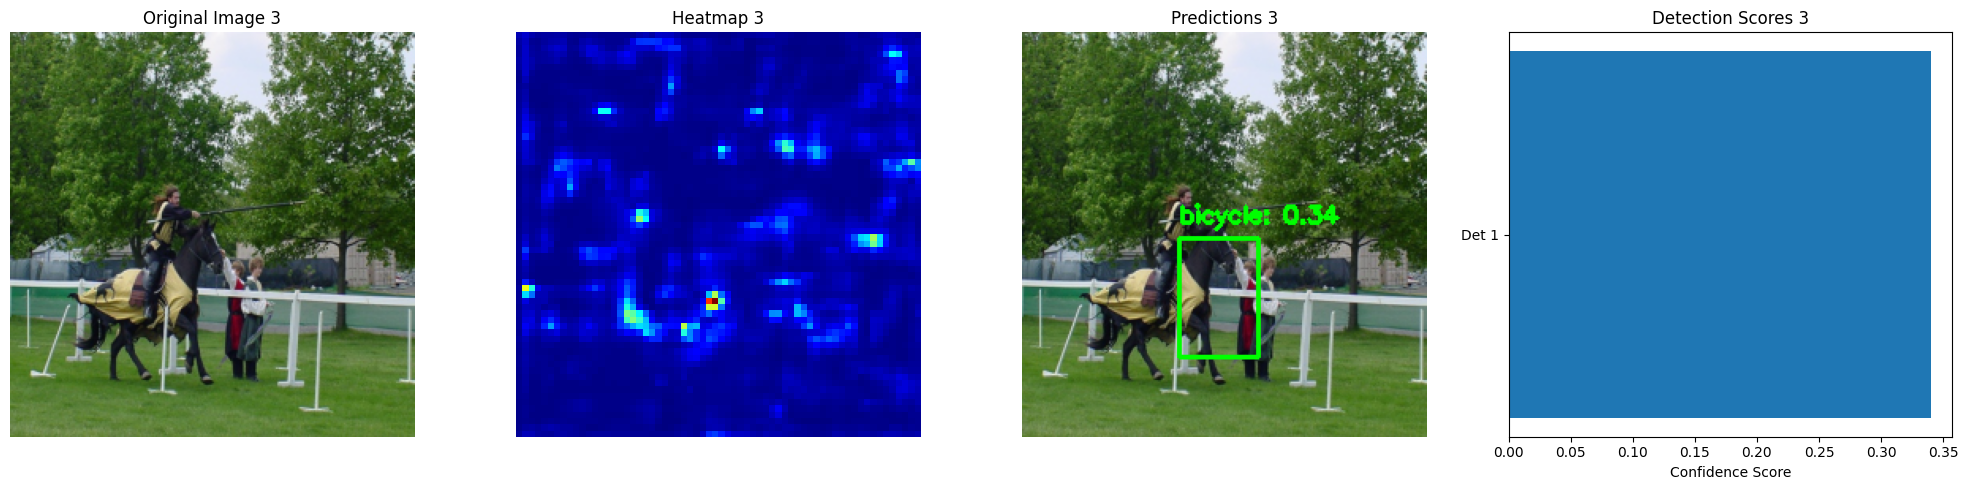

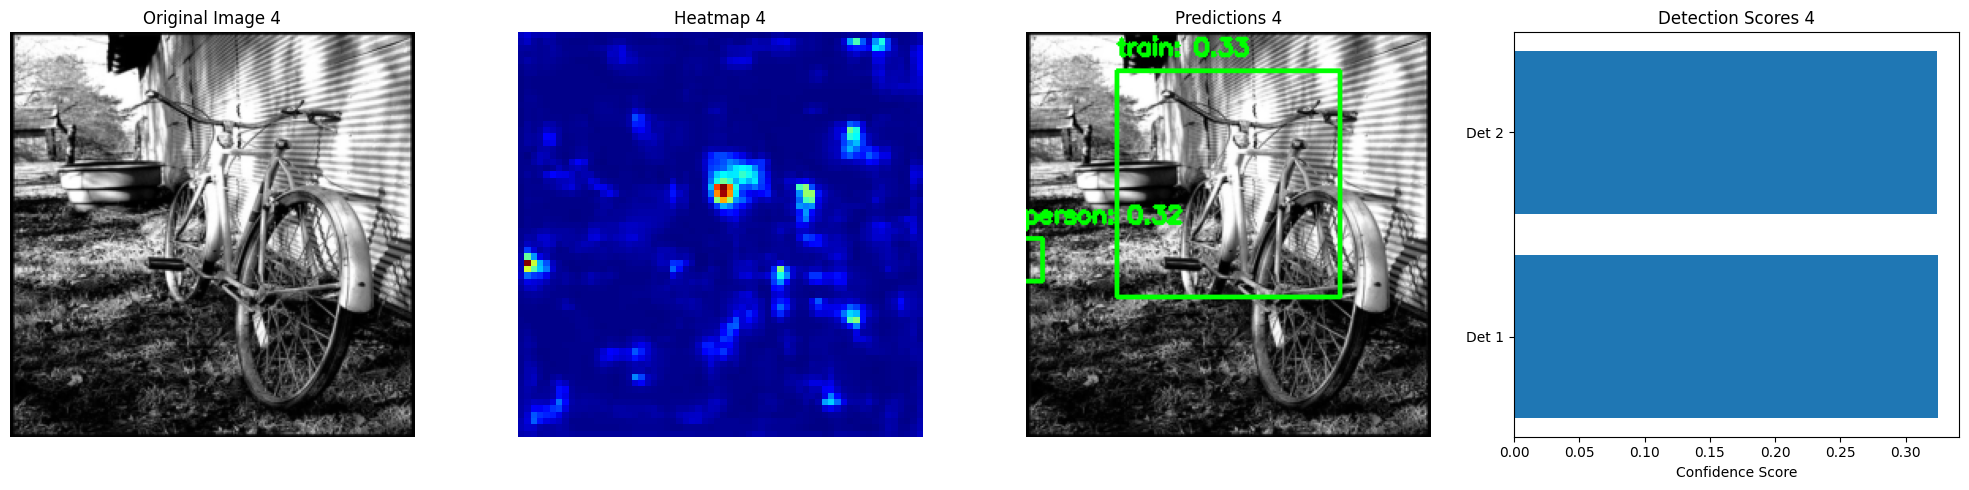

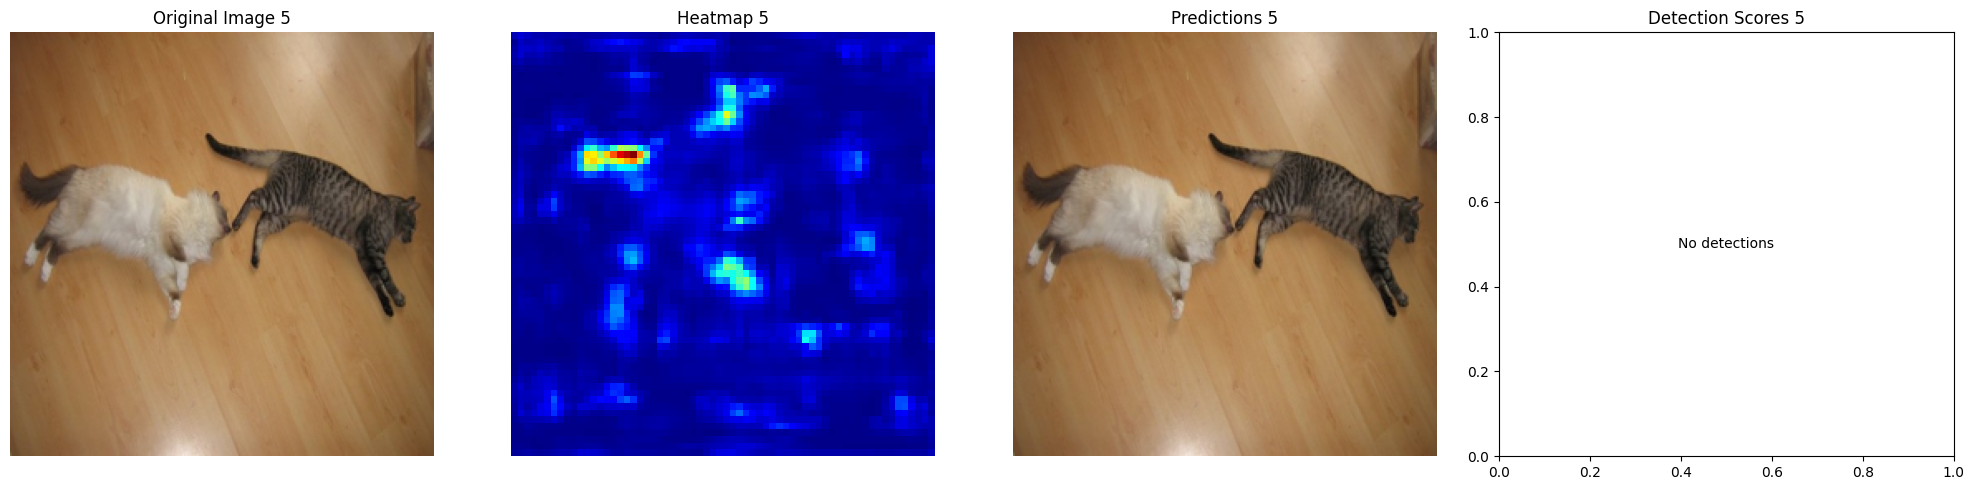

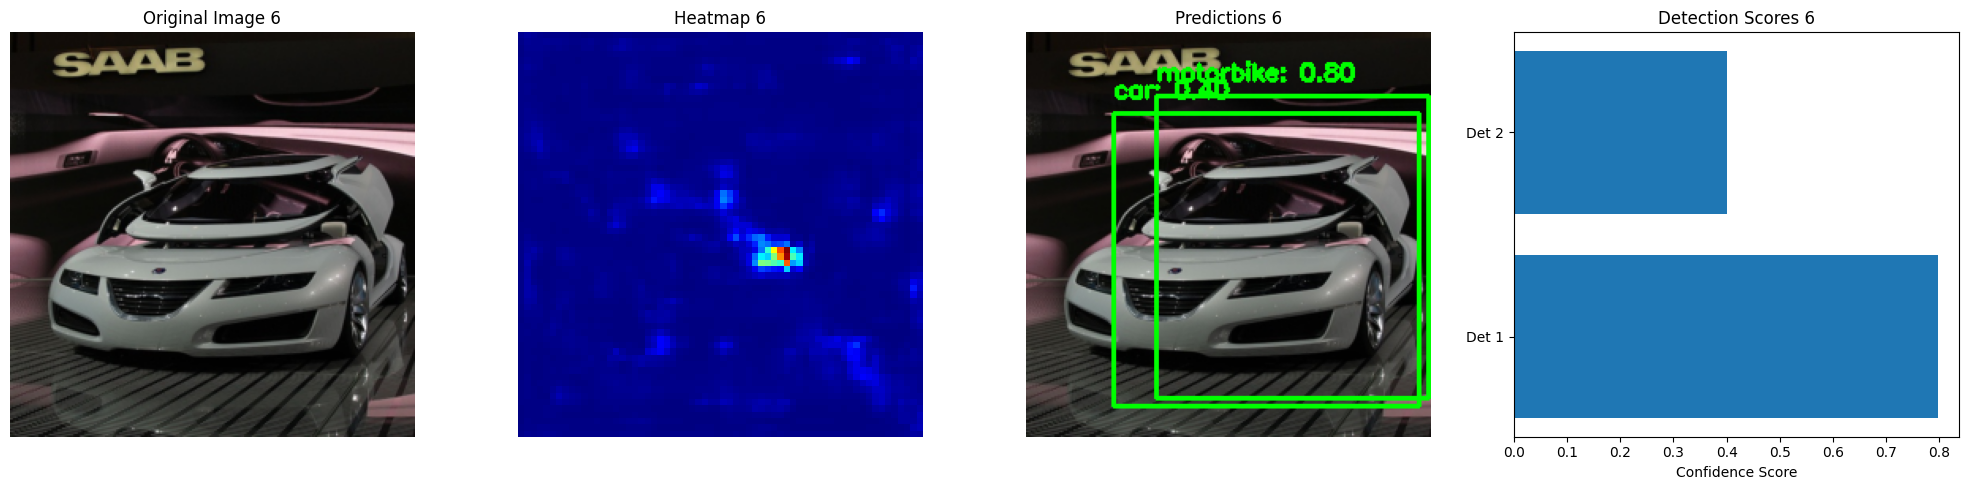

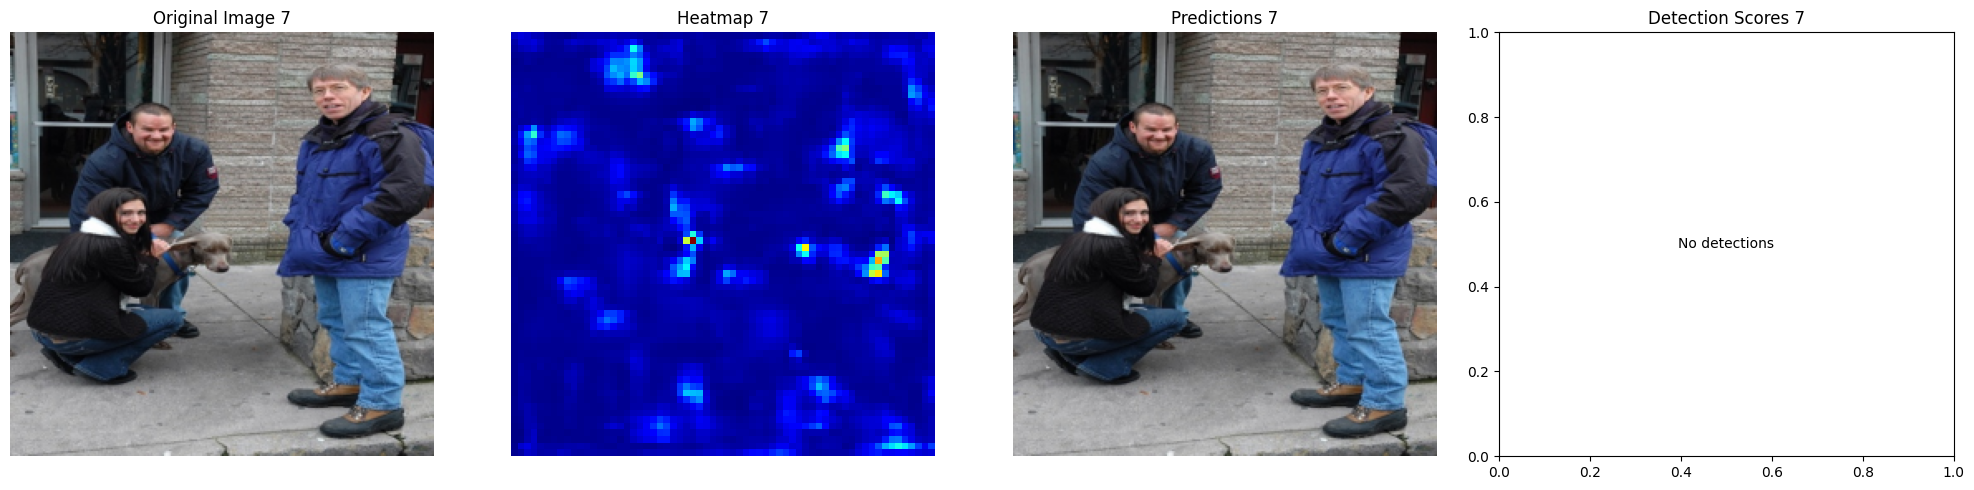

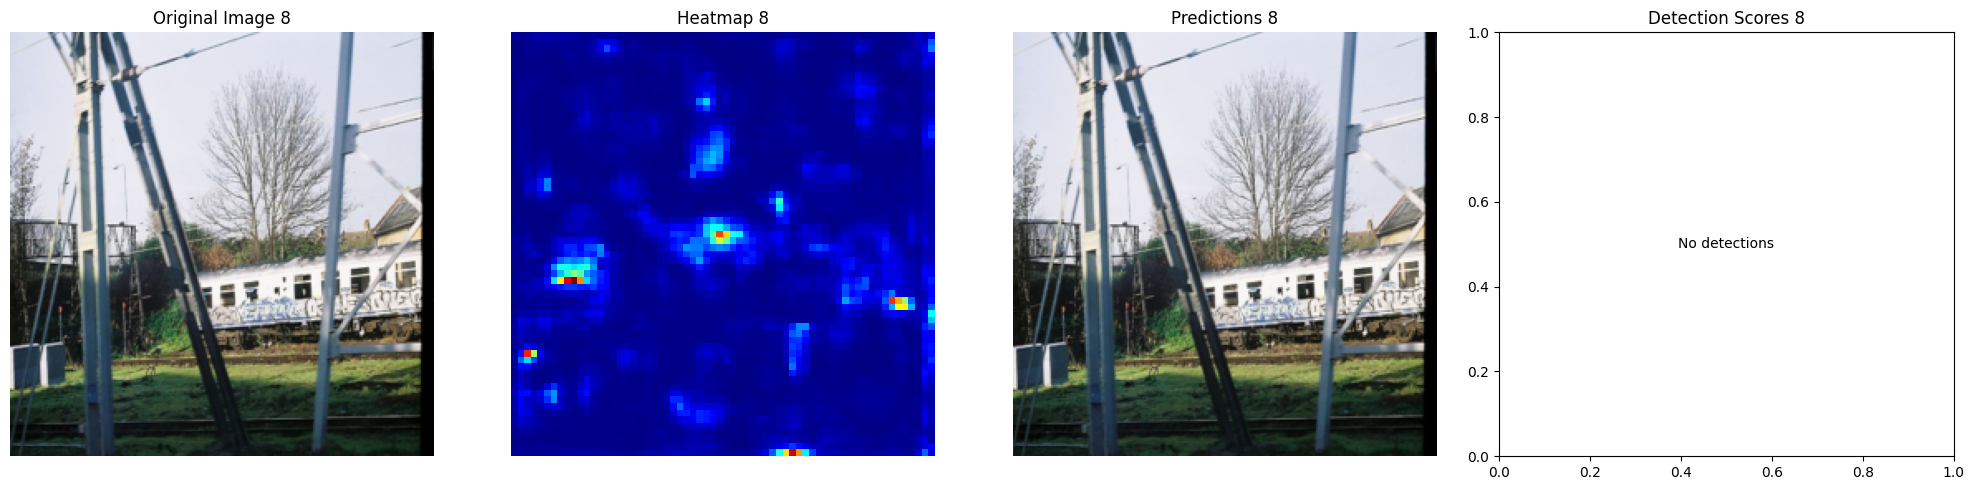

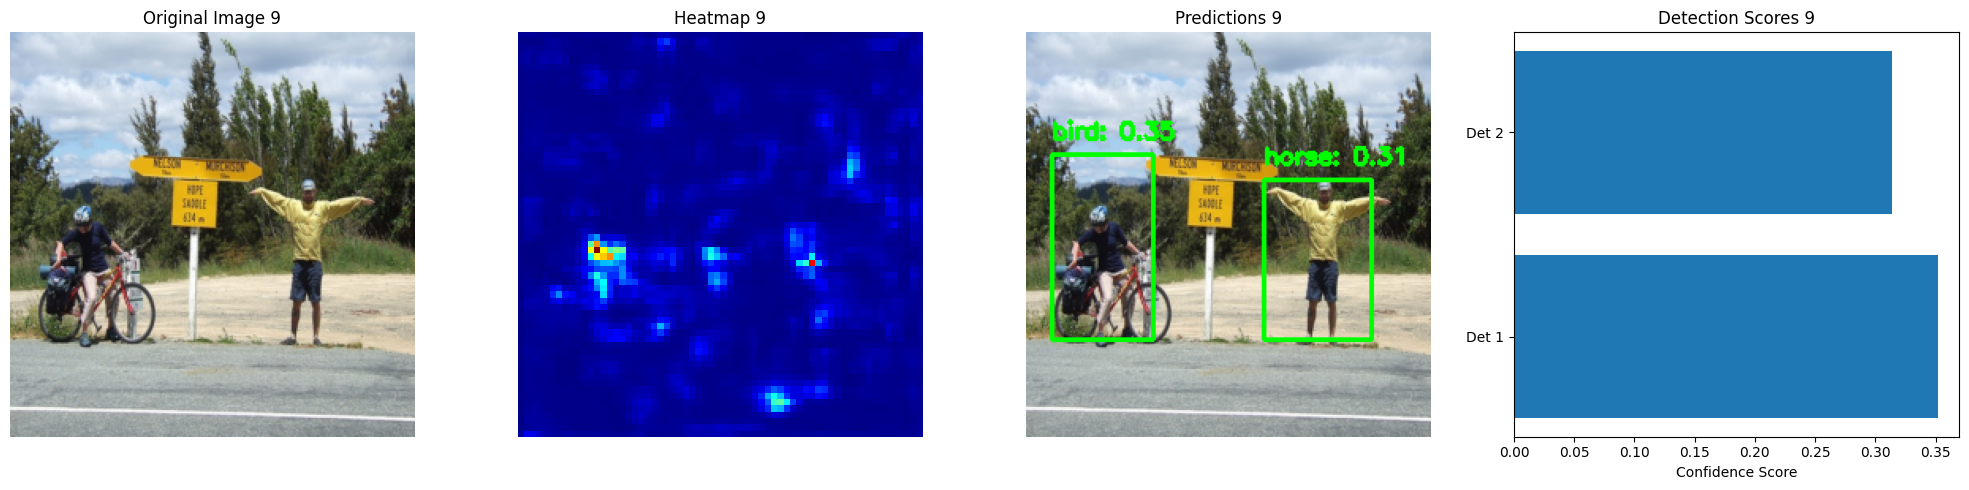

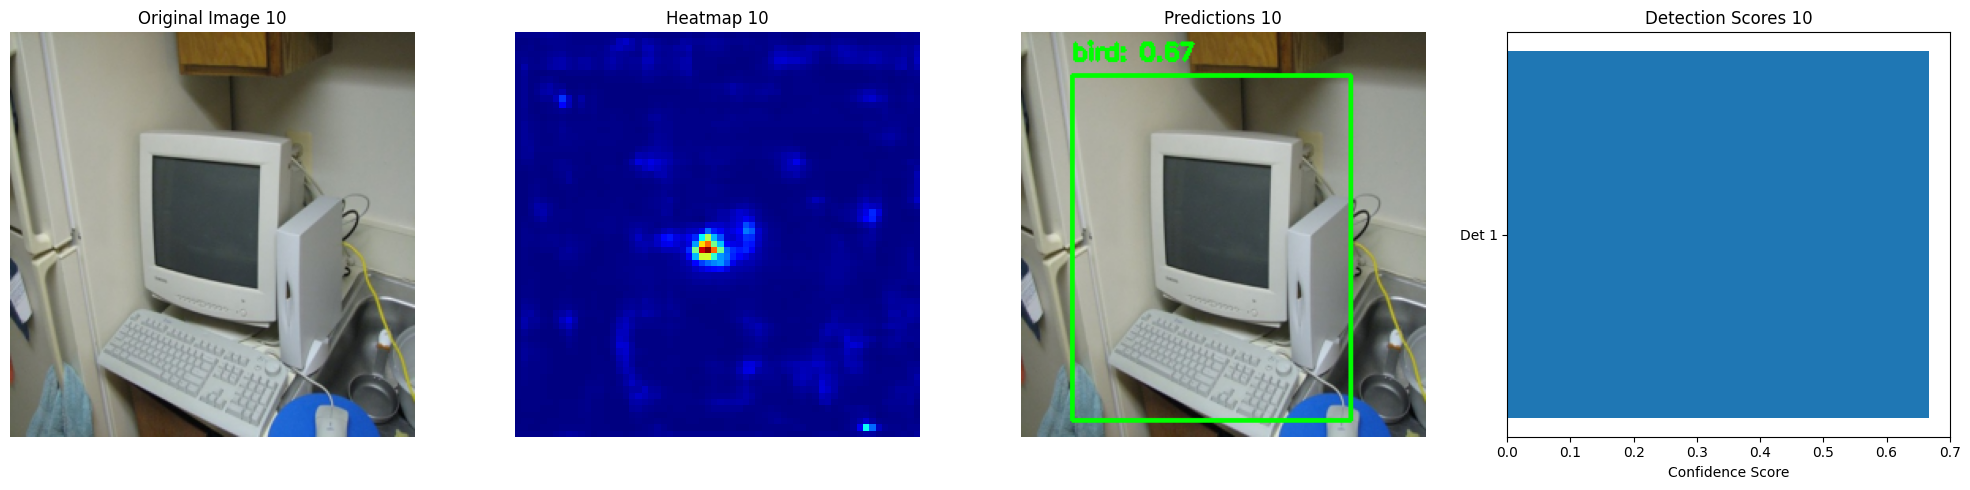

In [2]:
import os
from typing import TypeVar
import torchvision
from torchvision.transforms import v2 as transforms
import torch
import torch.nn as nn
from models.centernet import ModelBuilder
from models.resnet import ResnetModel
from data.dataset_visualizer import ImageDatasetWithLabels
from torch.utils.data import Subset
from postprocess_visual.object_detection_visualizer import (
    ObjectDetectionVisualizer,
)

def prepare_dataset():
    dataset = torchvision.datasets.VOCDetection(
        root="../VOC", year="2007", image_set="val", download=True
    )
    dataset = torchvision.datasets.wrap_dataset_for_transforms_v2(dataset)
    indices = range(10)
    dataset = Subset(dataset, indices)

    transform = transforms.Compose(
        [
            transforms.Resize(size=(256, 256)),
        ]
    )

    return ImageDatasetWithLabels(dataset=dataset, transformation=transform)

dataset = prepare_dataset()

ModuleType = TypeVar("ModuleType", bound=nn.Module)


def load_model(model_type: ModuleType, checkpoint_path: str = None):
    checkpoint_path = (
        "../models/checkpoints/pretrained_weights_train_resnet18.pt"
        if checkpoint_path is None
        else checkpoint_path
    )
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_type().to(device)
    model.load_state_dict(
        torch.load(
            checkpoint_path,
            map_location=device,
            weights_only=True,
        )
    )
    model.eval()
    return model

model = load_model(ResnetModel)

custom_transforms = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
    ]
)
preds = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i, orig_img in enumerate(dataset):
    img = custom_transforms(orig_img)
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img)
        preds.append(pred)

# Create visualizer with default settings
visualizer = ObjectDetectionVisualizer(
    dataset=dataset, input_height=256, input_width=256, confidence_threshold=0.3
)

# Visualize predictions
visualizer.visualize_predictions(preds)